In [1]:
%pip install -U -q git+https://github.com/facebookresearch/audiocraft#egg=audiocraft
%pip install -q mutagen
%pip install -q transformers
%pip install -q loguru

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 M

In [2]:
from rich.pretty import pprint

from audiocraft.models import musicgen
from audiocraft.utils.notebook import display_audio
from audiocraft.data.audio import audio_write

from mutagen.mp3 import MP3

from IPython.display import Audio

import torch

from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.0+cu118)
    Python  3.10.13 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


# Image used for try: https://images.app.goo.gl/oqnKNSLtzeN9hvco8

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
class ImageDescriber:
    def __init__(self, model_name: str, device: str) -> None:
        self._device = device

        self._processor = BlipProcessor.from_pretrained(model_name)
        self._model = BlipForConditionalGeneration.from_pretrained(model_name).to(
            device
        )

    def __call__(self, image_path: str) -> str:
        image_obj = Image.open(image_path).convert("RGB")
        inputs = self._processor(image_obj, return_tensors="pt").to(self._device)
        output = self._model.generate(**inputs)
        return self._processor.decode(output[0], skip_special_tokens=True)

--2023-11-17 20:43:06--  https://dl.dropbox.com/scl/fi/5k3bjs98z6ubb9m5zkrwb/xmasroom.jpeg?rlkey=qlxud26eieqpk77frh47dch9g
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.81.15, 2620:100:6031:15::a27d:510f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.81.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/scl/fi/5k3bjs98z6ubb9m5zkrwb/xmasroom.jpeg?rlkey=qlxud26eieqpk77frh47dch9g [following]
--2023-11-17 20:43:06--  https://dl.dropboxusercontent.com/scl/fi/5k3bjs98z6ubb9m5zkrwb/xmasroom.jpeg?rlkey=qlxud26eieqpk77frh47dch9g
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:6025:15::a27d:450f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.81.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122952 (120K) [image/jpeg]
Saving to: ‘xmasroom.jpeg’

xmasroom.jpeg       100%[===================>] 120.07K   273KB/s    in 0.4

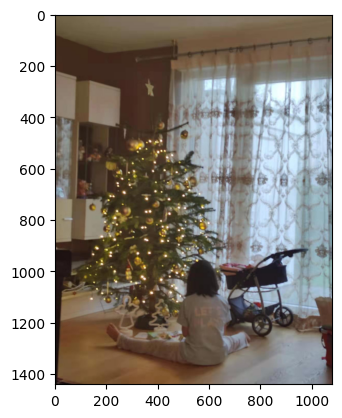

In [5]:
!wget -O xmasroom.jpeg https://dl.dropbox.com/scl/fi/5k3bjs98z6ubb9m5zkrwb/xmasroom.jpeg?rlkey=qlxud26eieqpk77frh47dch9g&dl=0

Image.open('xmasroom.jpeg').show()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('xmasroom.jpeg')
plt.imshow(img)
plt.show()

In [6]:
image_describer = ImageDescriber("Salesforce/blip-image-captioning-base", device)
res_base = image_describer("xmasroom.jpeg")
res_base

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a little girl sitting on the floor next to a christmas tree'

In [7]:
image_describer = ImageDescriber("Salesforce/blip-image-captioning-large", device)
res_large = image_describer("xmasroom.jpeg")
res_large

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

'there is a little girl sitting on the floor in front of a christmas tree'

In [8]:
model = musicgen.MusicGen.get_pretrained('medium', device=device)
model.set_generation_params(duration=10, temperature=.5, top_p=250, top_k=250)

/usr/local/lib/python3.10/dist-packages/audiocraft/models/musicgen.py:127: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-medium
  warnings.warn(


state_dict.bin:   0%|          | 0.00/3.68G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

compression_state_dict.bin:   0%|          | 0.00/236M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [9]:
musicgen_out = model.generate([res_large], progress=True)

In [10]:
display_audio(musicgen_out, sample_rate=32000)